# Porting an analysis from local to distributed

In this pair of notebooks, we will develop a prototype unsupervised analysis with sklearn and then port it to use Spark, as we might in real life.

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>


## K-means clustering using sklearn

Our starting point is a dataset, `~/Data/sales_segments.csv.gz`, which contains data for air reservations at segment level.

For each reservation, we get among others a `revenue_amount_seg` value, a `fuel_surcharge_amount_seg` value and a `bookings_seg` value. The first one represents the main amount paid to the airline and the second is referred to as 'tax', but reflects a different kind of revenue that in principle should be roughly proportional to the first kind. The third is the number of persons booked for the segment in question.

The rationale here is that the business side has detected that some of the segments are probably wrong and requested an automated way to detect suspicious segments based on their revenue / fuel_surcharge ratio.

How do you think we could do that in a scalable way?

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('sales_segments.csv.gz', sep = '^')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (40,44,45,47,48,57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### First, inspect the data 

In [5]:
df.head()

,rloc,departure_date_seg,booking_date,freq_flyer_flag,creator_office_id,creator_iata_number,creator_gds_code,creator_city_code,creator_lat,creator_lon,...,bookings_seg,rpk_seg,revenue_amount_seg,currency_code,fuel_surcharge_amount_seg,fuel_surcharge_currency_code,emd_count,emd_amount,emd_currency_code,total_outliers
0,59GS9Y,2013-12-21,2013-09-05,False,RUNHS3103,66200201.0,1A,RUN,-20.90083,55.53715,...,1,239,33.56,EUR,7.30,EUR,0,0.0,NaN,7.300000
1,4D87YU,2013-12-29,2013-01-29,False,RUNUU000B,66490104.0,UU,RUN,-20.90083,55.53715,...,5,1116,306.00,EUR,127.50,EUR,0,0.0,NaN,77.271017
2,7W67K8,2013-12-29,2013-02-05,False,RUNUU01A3,66490830.0,UU,RUN,-20.90083,55.53715,...,19,4240,1365.50,EUR,234.00,EUR,0,0.0,NaN,278.175661
3,3ESPWM,2013-12-29,2013-03-19,False,RUNUU010C,66490771.0,UU,RUN,-20.90083,55.53715,...,3,1220,81.35,EUR,39.93,EUR,0,0.0,NaN,32.458243
4,6ITPJM,2013-12-29,2013-05-11,False,MRSA12108,20261721.0,1A,MRS,43.29695,5.38107,...,2,1342,0.00,EUR,31.82,EUR,0,0.0,NaN,32.496507


In [7]:
# Revenue amount segment es el precio del billete
# Fuel surchage amount es lo que suman al billete para calcular el coste total.

df[['revenue_amount_seg', 'fuel_surcharge_amount_seg', 'bookings_seg']].describe()

,revenue_amount_seg,fuel_surcharge_amount_seg,bookings_seg
count,1.459121e+06,1.459121e+06,1.459121e+06
mean,3.699153e+02,1.625172e+02,1.801091e+00
std,4.340001e+03,2.915060e+02,2.237350e+00
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,8.850000e+01,2.947000e+01,1.000000e+00
50%,1.988100e+02,7.508000e+01,1.000000e+00
75%,3.962600e+02,2.003100e+02,2.000000e+00
max,1.392156e+06,5.083673e+04,2.650000e+02


Hay valores que son absurdos. Por ejemplo, el máximo del coste revenue_amount_seg es 1 millón euros

### Calculate KPIs

* "revenue" per person
* "tax" per person


In [8]:
df['revenue'] = df['revenue_amount_seg'] / df ['bookings_seg']
df['tax'] = df['fuel_surcharge_amount_seg'] / df ['bookings_seg']

simple_df = df[['revenue', 'tax']]

In [9]:
simple_df.head()

,revenue,tax
0,33.560000,7.300000
1,61.200000,25.500000
2,71.868421,12.315789
3,27.116667,13.310000
4,0.000000,15.910000


### Inspect the distributions

In [10]:
simple_df.shape

(1459121, 2)

Si intentamos plotear mas de 1e de puntos tarda muchísimo.
Por tanto, sacamos una muestra

In [11]:
sample = simple_df.sample(20000, random_state=42)

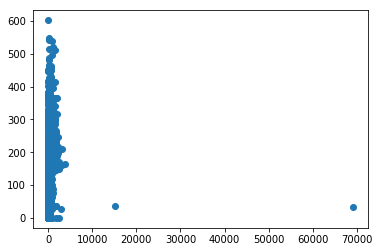

In [12]:
plt.scatter(sample['revenue'], sample['tax'])

Hay algunos outliers demasiado grandes

(-50, 1500)

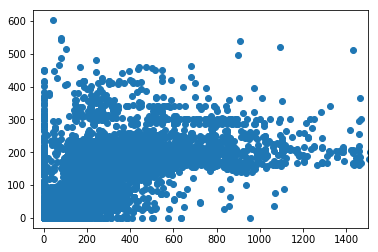

In [14]:
plt.scatter(sample['revenue'], sample['tax'])
plt.xlim((-50, 1500))

(-50, 1500)

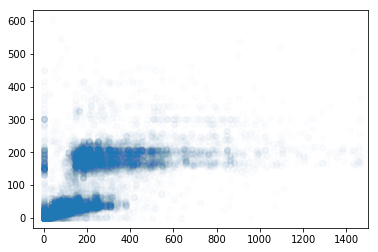

In [15]:
plt.scatter(sample['revenue'], sample['tax'], alpha=0.01)
plt.xlim((-50, 1500))

Esto no tiene una distribución gausiana, por lo que identificar outliers con z-score no es lo mas adecuado.
Es mejor hacer clusters, con distribución gausiana, y ya sacar los outliers ahi.

## Now for some learning!

It seems there are at least two or three groups of segments.

What we are going to do is to separate them into clusters with kmeans, then use the z-score as an outlier score.

#### Training a model with sklearn is quick and easy

We just use `.fit` and then `.predict`. As we'll see, this is very similar to Spark ML.

In [29]:
from sklearn.cluster import KMeans

## No hace falta pasar ningún parámetro, xq todos son opcionales en sklearn.
## Sin embargo, es bueno pasarle al menos el número de clusters
# Antes de hacer el cluster, es esencial NORMALIZAR !!!!!! Aqui no lo vamos a hacer
kmeans = KMeans(3)



In [18]:
kmeans.fit(simple_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
# Todas las variables que se llaman con el prefijo "_" son las aprendidas durante el .fit
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [20]:
simple_df.values.shape

(1459121, 2)

### But, how do we know 3 clusters is the appropriate number?

We can use the [Elbow method][1]

[1]: https://en.wikipedia.org/wiki/Elbow_method_(clustering)

Now we get each point's distance to its correponding centroid, which is the minimum for each row of the resulting matrix:

And we take either the sum or mean of the resultting vector:


Once we're sure it works, we can do it for n number of clusters:

#### Let's plot the curve

It was that easy! now let's see what we got:

### Let's have a look

In [21]:

kmeans = KMeans(8)
kmeans.fit(simple_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
kmeans.predict(simple_df)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

Aqui no separamos entre train y test, xq estamos en un aprendizaje no supervisado y no tenemos con qué comparar

In [24]:
simple_df['cluster'] = kmeans.predict(simple_df)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
simple_df.head()

,revenue,tax,cluster
0,33.560000,7.300000,0
1,61.200000,25.500000,0
2,71.868421,12.315789,0
3,27.116667,13.310000,0
4,0.000000,15.910000,0


In [27]:
simple_df.groupby('cluster').revenue.count()

cluster
0    1253892
1          8
2         16
3         95
4          1
5         10
6         46
7     205053
Name: revenue, dtype: int64

(-50, 1500)

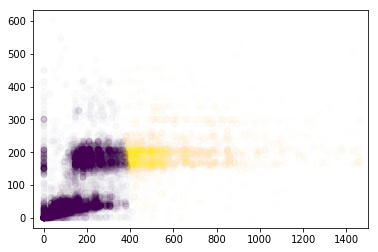

In [30]:
sample = simple_df.sample(20000, random_state=42)
plt.scatter(sample['revenue'], sample['tax'], alpha=0.01, c=sample['cluster'])
plt.xlim((-50, 1500))

### Z scores

Now we only need to calculate a z-score, so that we can score points as outliers or not outliers.



#### Calculate means and standard deviations in each direction for each cluster

In [34]:
means = simple_df.groupby('cluster').mean()
stds = simple_df.groupby('cluster').std()

stats = means.merge(stds, left_index=True, right_index=True, suffixes=('_mean', '_std'))
stats

,revenue_mean,tax_mean,revenue_std,tax_std
cluster,,,,
0,1.354585e+02,78.651678,96.756998,79.475995
1,6.152070e+05,29.731250,53170.300072,1.542099
2,3.467367e+05,102.778125,52460.589267,112.845184
3,1.122863e+05,21.696947,22148.322086,65.610380
4,1.392156e+06,32.740000,NaN,NaN
5,8.775004e+05,30.302000,50236.153381,1.808823
6,4.391545e+04,33.071603,12642.971758,34.736983
7,6.474493e+02,196.278578,429.121112,54.048664


Sale un NAN porque ese grupo sólo tiene 1 miembro

#### And annotate each point with the stats for its cluster

In [37]:
simple_df = simple_df.merge(stats, left_on=['cluster'], right_index=True, how='left')
simple_df.head()

,revenue,tax,cluster,revenue_mean,tax_mean,revenue_std,tax_std
0,33.560000,7.300000,0,135.458488,78.651678,96.756998,79.475995
1,61.200000,25.500000,0,135.458488,78.651678,96.756998,79.475995
2,71.868421,12.315789,0,135.458488,78.651678,96.756998,79.475995
3,27.116667,13.310000,0,135.458488,78.651678,96.756998,79.475995
4,0.000000,15.910000,0,135.458488,78.651678,96.756998,79.475995


In [38]:
simple_df.shape

(1459121, 7)

In [40]:
simple_df['z_revenue'] = (simple_df['revenue'] - simple_df['revenue_mean'])/simple_df['revenue_std']
simple_df['z_tax'] = (simple_df['tax'] - simple_df['tax_mean'])/simple_df['tax_std']
simple_df['z_score_sq'] = simple_df['z_revenue'] ** 2 + simple_df['z_tax'] ** 2

# PAra calcular la z conjunta es la raiz cuadrada de la suma de los cuadrados
# Es util visualizarlo en dos dimensiones y ver que es la diagonal del rectanculo
# Nos ahorramos la raiz cuadrada aqui xq es una c´laclo muy costoso y no nos aporta nada

simple_df.head()


,revenue,tax,cluster,revenue_mean,tax_mean,revenue_std,tax_std,z_revenue,z_tax,z_score_sq
0,33.560000,7.300000,0,135.458488,78.651678,96.756998,79.475995,-1.053138,-0.897776,1.915103
1,61.200000,25.500000,0,135.458488,78.651678,96.756998,79.475995,-0.767474,-0.668777,1.036278
2,71.868421,12.315789,0,135.458488,78.651678,96.756998,79.475995,-0.657214,-0.834666,1.128597
3,27.116667,13.310000,0,135.458488,78.651678,96.756998,79.475995,-1.119731,-0.822156,1.929739
4,0.000000,15.910000,0,135.458488,78.651678,96.756998,79.475995,-1.399986,-0.789442,2.583181


In [43]:
outliers = simple_df[['revenue', 'tax', 'cluster', 'z_score_sq']]
outliers['outlier'] = outliers['z_score_sq'] > 9
outliers.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,revenue,tax,cluster,z_score_sq,outlier
0,33.560000,7.300000,0,1.915103,False
1,61.200000,25.500000,0,1.036278,False
2,71.868421,12.315789,0,1.128597,False
3,27.116667,13.310000,0,1.929739,False
4,0.000000,15.910000,0,2.583181,False


#### Now we are ready to calculate the z scores

### How does this perform as an outlier detection method?

(-50, 750)

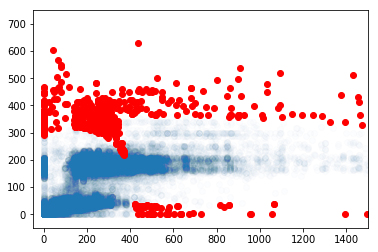

In [46]:
sample = outliers.sample(50000, random_state=42)
only_outlier = sample[sample['outlier']]

plt.scatter(sample['revenue'], sample['tax'], alpha=0.01)
plt.scatter(only_outlier['revenue'], only_outlier['tax'], c='Red')
plt.xlim((-50, 1500))
plt.ylim((-50, 750))

### Appendix: saving models in sklearn

## OK, let's move this to a more public place: the cluster!